## Var name setting

In [1]:
subjectID='9'
noEpochs=950
noLSTMUnits=100

# Change to true if input file 's features are sorted by time (False by default) 
orderedInput=True

# Change at least one of these 2 variable to true for reading inputFeatures (Can be both)
fourInputFeats=False
onlyVel=True

HRInputFeats=False
assert onlyVel==True or fourInputFeats == True or HRInputFeats==True, "Both condition are false!! Need at least one of these 2 variables to true"

# Change number of steps according to Matlab file for testing input data
test_noTimeSteps=50 

# Change to 1 if want to export to CSV O2 precict against test (0 by default)
exportCSV=1

# Chabge to 1 if want to save the training model (0 by default)
savedModel=1

# Set seed value for uniform (NOT RECOMMEND TO CHANGE, by default 12321)
seed_value = 1

# Getting input file name
if orderedInput:
    orderedPrefix = 'order-'
    sortedPrefix = '_sored'
    fileName='inputFeatures'+subjectID+'_sorted.mat'
else:    
    # Unordered input features
    orderedPrefix = ''
    sortedPrefix = ''
    fileName='inputFeatures'+subjectID+'.mat'

## For testinng purpose
#fileName="inputFeatures29_sorted.mat"
#fileName='inputFeatures9_sorted_99.mat'
print("Input file: ",fileName)

Input file:  inputFeatures9_sorted.mat


## Include lib

In [2]:
from keras.models import load_model
import scipy.io as sio 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
from datetime import datetime as dt
from keras import backend as K
from keras.callbacks import EarlyStopping

#from comet_ml import Experiment

## Set seed for training

In [3]:
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Defilne parser function

In [4]:
list_test=[]

"""
The function take number of feature according to data 
and return a list normalized input features data
"""
def parse_input(noFeatures):
    global list_test
    print("Number of features: ",noFeatures)
    if noFeatures==5:
        print("Keep all data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData)
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData)
    elif noFeatures==4:
        print("Remove HR data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,:4])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,:4])
    elif noFeatures==1 and onlyVel==1:
        print("Only vel feature")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,[1]])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,[1]])
    elif noFeatures==1 and onlyVel==0:
        print("Only HR data")
        for i in range(len(test)):
            temp_trainData=np.transpose(np.array(test[i]))
            list_test.append(temp_trainData[:,[-1]])
        for j in range(len(test2)):  
            temp_testData=np.transpose(np.array(test2[j]))
            list_test.append(temp_testData[:,[-11]])
    else:
        # Code will runinto this part
        print("Unknown number of features")
        
    print("---------")
    print(np.shape(list_test))    
    list_test=np.vstack(list_test)
    print(np.shape(list_test))
    scaler = StandardScaler()
    scaler=scaler.fit(list_test)
    scaled_list_test=scaler.transform(list_test)
    
    return scaled_list_test

## Read input from Matlab file

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

i=sio.loadmat(fileName)

TTest=i['TTest']
TTrain=i['TTrain']
XTrain=i['XTrain']
XTest=i['XTest']

XTrain=XTrain.reshape(-1)
TTrain=TTrain.reshape(-1)
XTest=XTest.reshape(-1)
TTest=TTest.reshape(-1)

test=np.transpose(XTrain).reshape(-1)
test2=np.transpose(XTest).reshape(-1)

print(np.shape(test[0]))
print(np.shape(test2[0]))

# Get number of features and number of number of time steps
#noFeatures = np.shape(test[0])[0]
noTimeSteps = np.shape(test[0])[1]
#print(noFeatures)

# Validate the input data's number of feature and number of time step
assert noTimeSteps == test_noTimeSteps, "The number of time steps does not match our configuration!! Check either of them"
print("The time step now should be ",noTimeSteps)

if fourInputFeats and HRInputFeats:
    #assert noFeatures==5, "The number of input features is not 5! Check setting again"
    print("5 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp, heart rate")
    confPrefix="withHR_"
    noFeatures=5
elif fourInputFeats:
    #assert noFeatures==4, "The number of input features is not 4! Check setting again"
    print("4 input features included: speed, speedChange, stepDuration, vertOscillation_dist_amp")
    confPrefix="NoHR_"
    noFeatures=4
elif HRInputFeats:
    print("1 input feture included: heart rate")
    confPrefix="onlyHR_"
elif onlyVel:
    #assert noFeatures==1, "The number of input features is not 1! Check setting again"
    print("1 input feture included: speed")
    confPrefix="onlyVel_"
    noFeatures=1
else:
    ## Both conditions are false, code will not run into this section
    print("Both condition are false!! Need at least ")
    
# Automatically setting name of output files based on configuration    
modelSaveName=confPrefix+'Subj-'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.h5'
figPredictName=confPrefix+'Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'
figRMSEName=confPrefix+'RMSE_Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+orderedPrefix+str(noLSTMUnits)+'-LSTM_u.jpg'

(5, 50)
(5, 50)
The time step now should be  50
1 input feture included: speed


## Call parser function

In [6]:
scaled_list_test = parse_input(noFeatures)

# Return back input data with scaled value
XT_s_stack=list()
i=0
timeSteps=noTimeSteps
while i+timeSteps <= (len(scaled_list_test)):
    XT_s_stack.append(scaled_list_test[i:i+timeSteps])
    i=i+timeSteps

XT_s_stack=np.stack(XT_s_stack)
cutPoint=np.shape(TTest.reshape(-1))[0]


XTrain_s=XT_s_stack[:-cutPoint,:,:]
XTest_s=XT_s_stack[-cutPoint:,:,:]

Number of features:  1
Only vel feature
---------
(1344, 50, 1)
(67200, 1)


## Configure the model

In [7]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=20)

In [8]:
length = noTimeSteps
n_features = noFeatures
model = Sequential()
model.add(LSTM(noLSTMUnits,input_shape=(length,n_features)))
model.add(Dense(1))
opt=Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mean_squared_logarithmic_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
#print(np.shape(XTrain_s))
#print(np.isnan(XTrain_s))
#print(XTrain_s)

In [10]:
# print(np.shape(TTrain))
# TTrain[np.isnan(TTrain)]=0
# print(TTrain)

In [11]:
#TTrain[np.isnan(TTrain)]=0
with tf.device('/gpu:0'):
    start = dt.now()
    hist=model.fit(XTrain_s,np.array(TTrain),epochs=noEpochs,verbose=2)
    trainTime=(dt.now() - start)

Epoch 1/950
34/34 - 3s - loss: 2.9238 - 3s/epoch - 81ms/step
Epoch 2/950
34/34 - 1s - loss: 1.6034 - 819ms/epoch - 24ms/step
Epoch 3/950
34/34 - 1s - loss: 1.5906 - 875ms/epoch - 26ms/step
Epoch 4/950
34/34 - 1s - loss: 1.5895 - 781ms/epoch - 23ms/step
Epoch 5/950
34/34 - 1s - loss: 1.5894 - 797ms/epoch - 23ms/step
Epoch 6/950
34/34 - 1s - loss: 1.5894 - 810ms/epoch - 24ms/step
Epoch 7/950
34/34 - 1s - loss: 1.5894 - 899ms/epoch - 26ms/step
Epoch 8/950
34/34 - 1s - loss: 1.5894 - 858ms/epoch - 25ms/step
Epoch 9/950
34/34 - 1s - loss: 1.5895 - 914ms/epoch - 27ms/step
Epoch 10/950
34/34 - 1s - loss: 1.5896 - 785ms/epoch - 23ms/step
Epoch 11/950
34/34 - 1s - loss: 1.5894 - 817ms/epoch - 24ms/step
Epoch 12/950
34/34 - 1s - loss: 1.5896 - 762ms/epoch - 22ms/step
Epoch 13/950
34/34 - 1s - loss: 1.5897 - 798ms/epoch - 23ms/step
Epoch 14/950
34/34 - 1s - loss: 1.5896 - 784ms/epoch - 23ms/step
Epoch 15/950
34/34 - 1s - loss: 1.5896 - 800ms/epoch - 24ms/step
Epoch 16/950
34/34 - 1s - loss: 1.589

Epoch 127/950
34/34 - 1s - loss: 0.0722 - 843ms/epoch - 25ms/step
Epoch 128/950
34/34 - 1s - loss: 0.0713 - 797ms/epoch - 23ms/step
Epoch 129/950
34/34 - 1s - loss: 0.0703 - 799ms/epoch - 23ms/step
Epoch 130/950
34/34 - 1s - loss: 0.0717 - 773ms/epoch - 23ms/step
Epoch 131/950
34/34 - 1s - loss: 0.0724 - 822ms/epoch - 24ms/step
Epoch 132/950
34/34 - 1s - loss: 0.0703 - 817ms/epoch - 24ms/step
Epoch 133/950
34/34 - 1s - loss: 0.0729 - 796ms/epoch - 23ms/step
Epoch 134/950
34/34 - 1s - loss: 0.0675 - 787ms/epoch - 23ms/step
Epoch 135/950
34/34 - 1s - loss: 0.0726 - 805ms/epoch - 24ms/step
Epoch 136/950
34/34 - 1s - loss: 0.0700 - 786ms/epoch - 23ms/step
Epoch 137/950
34/34 - 1s - loss: 0.0691 - 811ms/epoch - 24ms/step
Epoch 138/950
34/34 - 1s - loss: 0.0752 - 777ms/epoch - 23ms/step
Epoch 139/950
34/34 - 1s - loss: 0.0678 - 819ms/epoch - 24ms/step
Epoch 140/950
34/34 - 1s - loss: 0.0649 - 771ms/epoch - 23ms/step
Epoch 141/950
34/34 - 1s - loss: 0.0698 - 883ms/epoch - 26ms/step
Epoch 142/

Epoch 252/950
34/34 - 1s - loss: 0.0239 - 849ms/epoch - 25ms/step
Epoch 253/950
34/34 - 1s - loss: 0.0238 - 820ms/epoch - 24ms/step
Epoch 254/950
34/34 - 1s - loss: 0.0233 - 834ms/epoch - 25ms/step
Epoch 255/950
34/34 - 1s - loss: 0.0310 - 793ms/epoch - 23ms/step
Epoch 256/950
34/34 - 1s - loss: 0.0327 - 1s/epoch - 31ms/step
Epoch 257/950
34/34 - 1s - loss: 0.0384 - 907ms/epoch - 27ms/step
Epoch 258/950
34/34 - 1s - loss: 0.0227 - 883ms/epoch - 26ms/step
Epoch 259/950
34/34 - 1s - loss: 0.0196 - 868ms/epoch - 26ms/step
Epoch 260/950
34/34 - 1s - loss: 0.0281 - 811ms/epoch - 24ms/step
Epoch 261/950
34/34 - 1s - loss: 0.0278 - 826ms/epoch - 24ms/step
Epoch 262/950
34/34 - 1s - loss: 0.0210 - 781ms/epoch - 23ms/step
Epoch 263/950
34/34 - 1s - loss: 0.0183 - 827ms/epoch - 24ms/step
Epoch 264/950
34/34 - 1s - loss: 0.0198 - 821ms/epoch - 24ms/step
Epoch 265/950
34/34 - 1s - loss: 0.0268 - 862ms/epoch - 25ms/step
Epoch 266/950
34/34 - 1s - loss: 0.0207 - 804ms/epoch - 24ms/step
Epoch 267/950

Epoch 377/950
34/34 - 1s - loss: 0.0056 - 799ms/epoch - 23ms/step
Epoch 378/950
34/34 - 1s - loss: 0.0050 - 844ms/epoch - 25ms/step
Epoch 379/950
34/34 - 1s - loss: 0.0044 - 796ms/epoch - 23ms/step
Epoch 380/950
34/34 - 1s - loss: 0.0042 - 825ms/epoch - 24ms/step
Epoch 381/950
34/34 - 1s - loss: 0.0042 - 800ms/epoch - 24ms/step
Epoch 382/950
34/34 - 1s - loss: 0.0041 - 822ms/epoch - 24ms/step
Epoch 383/950
34/34 - 1s - loss: 0.0039 - 804ms/epoch - 24ms/step
Epoch 384/950
34/34 - 1s - loss: 0.0038 - 829ms/epoch - 24ms/step
Epoch 385/950
34/34 - 1s - loss: 0.0037 - 798ms/epoch - 23ms/step
Epoch 386/950
34/34 - 1s - loss: 0.0037 - 832ms/epoch - 24ms/step
Epoch 387/950
34/34 - 1s - loss: 0.0038 - 781ms/epoch - 23ms/step
Epoch 388/950
34/34 - 1s - loss: 0.0037 - 840ms/epoch - 25ms/step
Epoch 389/950
34/34 - 1s - loss: 0.0036 - 803ms/epoch - 24ms/step
Epoch 390/950
34/34 - 1s - loss: 0.0035 - 922ms/epoch - 27ms/step
Epoch 391/950
34/34 - 1s - loss: 0.0034 - 882ms/epoch - 26ms/step
Epoch 392/

Epoch 500/950
34/34 - 1s - loss: 0.0037 - 859ms/epoch - 25ms/step
Epoch 501/950
34/34 - 1s - loss: 0.0026 - 826ms/epoch - 24ms/step
Epoch 502/950
34/34 - 1s - loss: 0.0023 - 840ms/epoch - 25ms/step
Epoch 503/950
34/34 - 1s - loss: 0.0017 - 820ms/epoch - 24ms/step
Epoch 504/950
34/34 - 1s - loss: 0.0015 - 942ms/epoch - 28ms/step
Epoch 505/950
34/34 - 1s - loss: 0.0014 - 918ms/epoch - 27ms/step
Epoch 506/950
34/34 - 1s - loss: 0.0014 - 912ms/epoch - 27ms/step
Epoch 507/950
34/34 - 1s - loss: 0.0012 - 828ms/epoch - 24ms/step
Epoch 508/950
34/34 - 1s - loss: 0.0064 - 832ms/epoch - 24ms/step
Epoch 509/950
34/34 - 1s - loss: 0.0051 - 839ms/epoch - 25ms/step
Epoch 510/950
34/34 - 1s - loss: 0.0024 - 804ms/epoch - 24ms/step
Epoch 511/950
34/34 - 1s - loss: 0.0057 - 817ms/epoch - 24ms/step
Epoch 512/950
34/34 - 1s - loss: 0.0054 - 830ms/epoch - 24ms/step
Epoch 513/950
34/34 - 1s - loss: 0.0071 - 833ms/epoch - 25ms/step
Epoch 514/950
34/34 - 1s - loss: 0.0136 - 808ms/epoch - 24ms/step
Epoch 515/

Epoch 621/950
34/34 - 1s - loss: 6.2879e-04 - 828ms/epoch - 24ms/step
Epoch 622/950
34/34 - 1s - loss: 5.5834e-04 - 812ms/epoch - 24ms/step
Epoch 623/950
34/34 - 1s - loss: 4.9951e-04 - 855ms/epoch - 25ms/step
Epoch 624/950
34/34 - 1s - loss: 4.6248e-04 - 849ms/epoch - 25ms/step
Epoch 625/950
34/34 - 1s - loss: 4.5890e-04 - 1s/epoch - 31ms/step
Epoch 626/950
34/34 - 1s - loss: 4.6458e-04 - 859ms/epoch - 25ms/step
Epoch 627/950
34/34 - 1s - loss: 4.2073e-04 - 848ms/epoch - 25ms/step
Epoch 628/950
34/34 - 1s - loss: 4.3957e-04 - 839ms/epoch - 25ms/step
Epoch 629/950
34/34 - 1s - loss: 4.0749e-04 - 815ms/epoch - 24ms/step
Epoch 630/950
34/34 - 1s - loss: 4.7467e-04 - 883ms/epoch - 26ms/step
Epoch 631/950
34/34 - 1s - loss: 4.6516e-04 - 853ms/epoch - 25ms/step
Epoch 632/950
34/34 - 1s - loss: 4.1136e-04 - 816ms/epoch - 24ms/step
Epoch 633/950
34/34 - 1s - loss: 3.6434e-04 - 828ms/epoch - 24ms/step
Epoch 634/950
34/34 - 1s - loss: 3.6784e-04 - 863ms/epoch - 25ms/step
Epoch 635/950
34/34 - 1

Epoch 741/950
34/34 - 1s - loss: 0.0016 - 865ms/epoch - 25ms/step
Epoch 742/950
34/34 - 1s - loss: 0.0013 - 947ms/epoch - 28ms/step
Epoch 743/950
34/34 - 1s - loss: 9.0925e-04 - 925ms/epoch - 27ms/step
Epoch 744/950
34/34 - 1s - loss: 7.5672e-04 - 980ms/epoch - 29ms/step
Epoch 745/950
34/34 - 1s - loss: 7.3527e-04 - 938ms/epoch - 28ms/step
Epoch 746/950
34/34 - 1s - loss: 6.2026e-04 - 807ms/epoch - 24ms/step
Epoch 747/950
34/34 - 1s - loss: 5.8781e-04 - 836ms/epoch - 25ms/step
Epoch 748/950
34/34 - 1s - loss: 5.5442e-04 - 855ms/epoch - 25ms/step
Epoch 749/950
34/34 - 1s - loss: 5.4857e-04 - 852ms/epoch - 25ms/step
Epoch 750/950
34/34 - 1s - loss: 5.5021e-04 - 810ms/epoch - 24ms/step
Epoch 751/950
34/34 - 1s - loss: 5.8236e-04 - 817ms/epoch - 24ms/step
Epoch 752/950
34/34 - 1s - loss: 5.0942e-04 - 862ms/epoch - 25ms/step
Epoch 753/950
34/34 - 1s - loss: 5.0418e-04 - 856ms/epoch - 25ms/step
Epoch 754/950
34/34 - 1s - loss: 5.0920e-04 - 835ms/epoch - 25ms/step
Epoch 755/950
34/34 - 1s - l

Epoch 859/950
34/34 - 1s - loss: 2.3478e-04 - 851ms/epoch - 25ms/step
Epoch 860/950
34/34 - 1s - loss: 2.1842e-04 - 806ms/epoch - 24ms/step
Epoch 861/950
34/34 - 1s - loss: 2.1928e-04 - 1s/epoch - 36ms/step
Epoch 862/950
34/34 - 1s - loss: 1.9392e-04 - 991ms/epoch - 29ms/step
Epoch 863/950
34/34 - 1s - loss: 1.9154e-04 - 831ms/epoch - 24ms/step
Epoch 864/950
34/34 - 1s - loss: 1.8255e-04 - 829ms/epoch - 24ms/step
Epoch 865/950
34/34 - 1s - loss: 1.9708e-04 - 872ms/epoch - 26ms/step
Epoch 866/950
34/34 - 1s - loss: 1.9465e-04 - 840ms/epoch - 25ms/step
Epoch 867/950
34/34 - 1s - loss: 1.8968e-04 - 821ms/epoch - 24ms/step
Epoch 868/950
34/34 - 1s - loss: 1.9794e-04 - 820ms/epoch - 24ms/step
Epoch 869/950
34/34 - 1s - loss: 1.9364e-04 - 835ms/epoch - 25ms/step
Epoch 870/950
34/34 - 1s - loss: 1.8435e-04 - 864ms/epoch - 25ms/step
Epoch 871/950
34/34 - 1s - loss: 1.6748e-04 - 842ms/epoch - 25ms/step
Epoch 872/950
34/34 - 1s - loss: 1.6503e-04 - 908ms/epoch - 27ms/step
Epoch 873/950
34/34 - 1

In [12]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# plt.figure(figsize=(35,15))
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epochs')
# plt.legend(['train', 'validation'], loc='upper right',prop={'size': 10})
# fig = plt.gcf()
# plt.yscale("log")
# fig.set_size_inches(20.5, 10.5)
# plt.show()

In [13]:
print("Train time: ",trainTime,"s")

Train time:  0:13:31.567656 s


## Inference

In [14]:
with tf.device('/cpu:0'):
    startInf = dt.now()
    Y_hat=model.predict(XTest_s)
    inferenceTime=(dt.now() - startInf)


9/9 [==============================] - 0s 10ms/step


In [15]:
print("Inference time: ",inferenceTime,"s")

Inference time:  0:00:00.527340 s


In [16]:
print(XTrain_s.shape)
print(TTrain.shape)

(1075, 50, 1)
(1075,)


## Plot prediction 

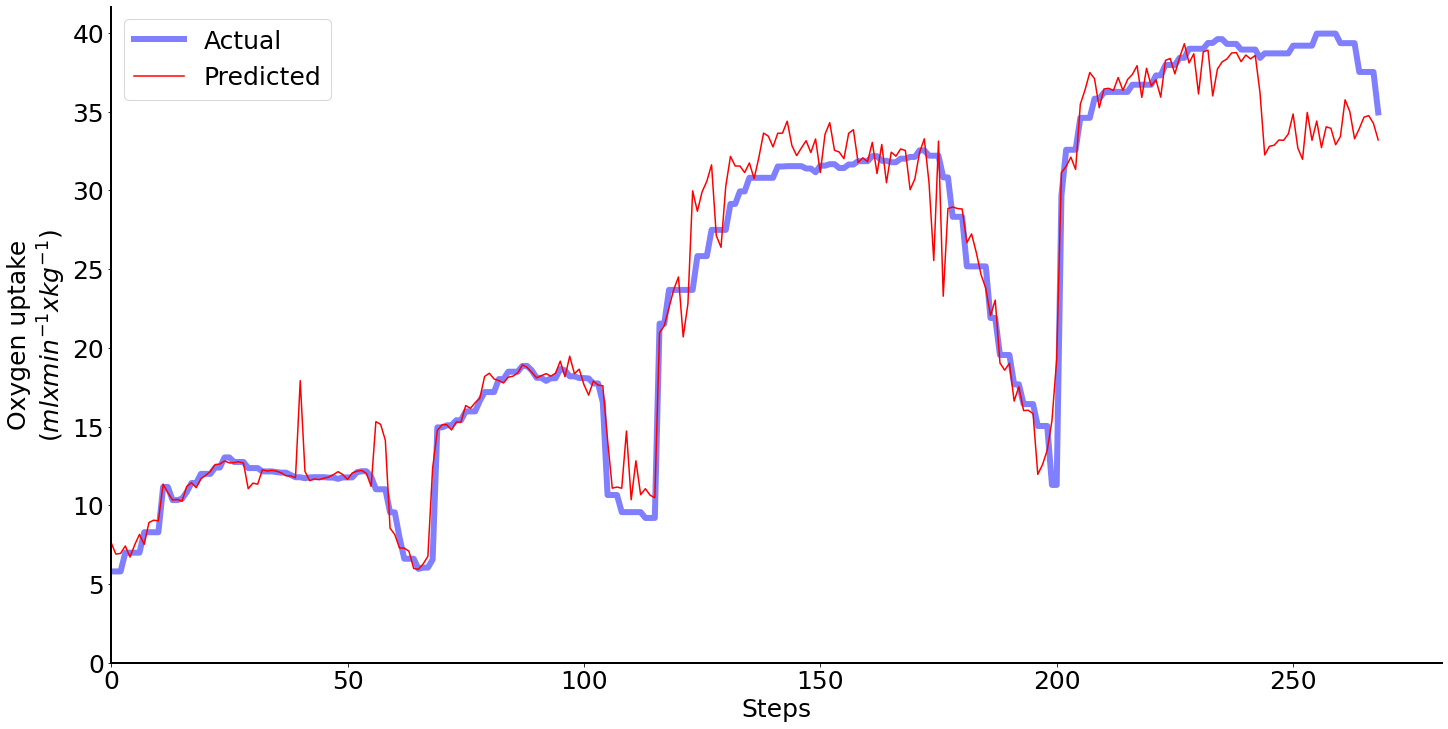

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(15,7))
plt.plot(TTest,color='blue',label='Actual',alpha=0.5,linewidth=6.0)
plt.plot(Y_hat,color='red',label='Predicted')
plt.xlabel('Steps',fontsize=25,backgroundcolor='w')
plt.ylabel("Oxygen uptake\n"+"$(mlxmin^{-1}xkg^{-1})$",fontsize=25,backgroundcolor='w')
plt.tight_layout()

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)

plt.ylim(0)
plt.xlim(0)

plt.legend(prop={'size': 25},loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
fig.savefig(figPredictName)
plt.show()

## Save model

In [18]:
if savedModel:
    model.save(modelSaveName)

In [19]:
print(np.shape(Y_hat))
print(np.shape(TTest))
#Y_hat=np.expand_dims(Y_hat,axis=0)
#TTest=np.expand_dims(TTest,axis=0)
#print(np.shape(XTrain_s))
#print(np.shape(TTrain))
results = model.evaluate(XTest_s,TTest)

(269, 1)
(269,)
9/9 [==============================] - 1s 10ms/step - loss: 0.0103


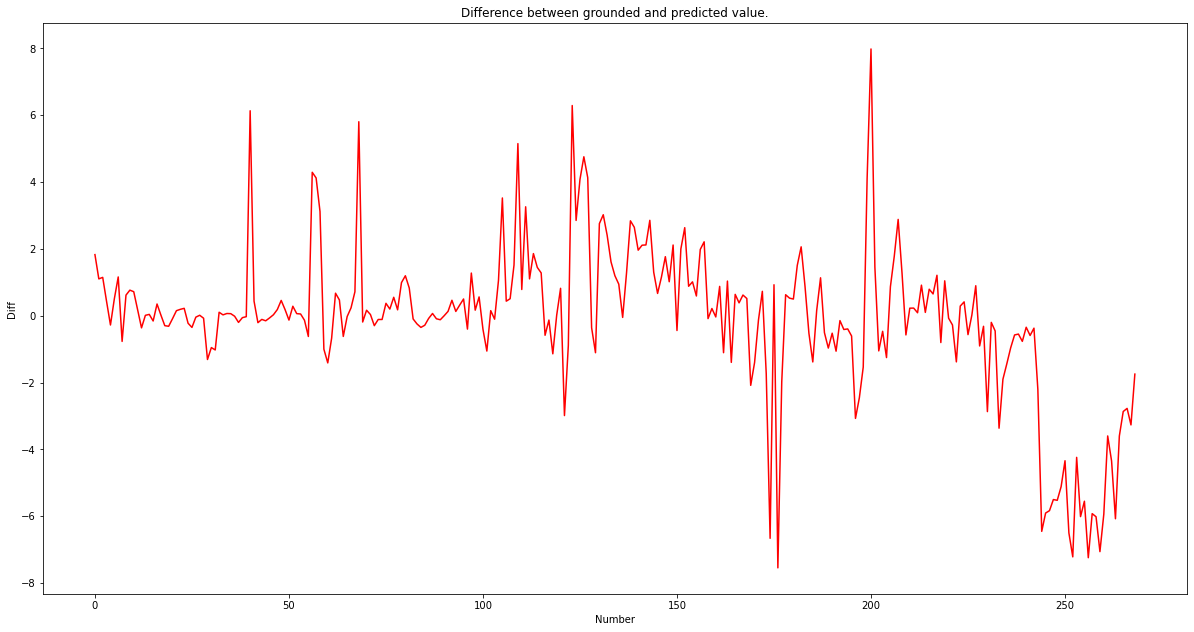

In [20]:
#Y_hat=np.transpose(Y_hat)
TTest=TTest.reshape(len(TTest),1)
#print(Y_hat)
#diff=np.concatenate((Y_hat,TTest),axis=1)
diff=np.subtract(Y_hat,TTest)
#print(diff)
plt.figure(figsize=(20.5,15.5))
plt.plot(diff,color='red')
plt.xlabel('Number')
plt.ylabel('Diff')
plt.title('Difference between grounded and predicted value.')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
#fig.savefig(figPredictName+'L_'+str(results)+'.jpg', dpi=150)
plt.show()
#model.save('1st-stage-subj-1.h5')

In [24]:
rmse=np.sqrt(np.square(np.subtract(TTest,Y_hat)).mean())
print("RMSE Error: ",rmse)

RMSE Error:  2.3114461289962143


In [22]:
res=np.concatenate((Y_hat,TTest,Y_hat-TTest,(Y_hat+TTest)/2),axis=1)
print(res)

if exportCSV:
    if HRInputFeats and fourInputFeats:
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-wHR.csv')
    elif HRInputFeats:        
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-oHR.csv')
    elif fourInputFeats:
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-noHR.csv')
    elif onlyVel:
        print("Store to oVel")
        pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict-oVel.csv')

[[ 7.63092041  5.8028      1.82812041  6.71686021]
 [ 6.90461922  5.8028      1.10181922  6.35370961]
 [ 6.94997311  5.8028      1.14717311  6.37638655]
 ...
 [34.75290298 37.526      -2.77309702 36.13945149]
 [34.25860596 37.526      -3.26739404 35.89230298]
 [33.20853043 34.956      -1.74746957 34.08226521]]
Store to oVel
